This notebook is for evaluating FHV taxi data for use in busyness data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os

In [2]:
# TODO: Iterate over the whole file
# Options:
# Do it with pyarrow slice by slice
parquet_file = "all_fhvhv_tripdata.parquet"
parquet_reader = pq.ParquetFile(parquet_file)


In [3]:
print(parquet_reader.schema.names)

['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID']


In [4]:
num_rows = parquet_reader.metadata.num_rows
num_row_groups = parquet_reader.num_row_groups
# df.shape[0]
print(num_rows)
print(num_row_groups)

679806621
669


In [5]:
rows_to_read = [i for i in range(0, num_row_groups, 5)]
table = parquet_reader.read_row_groups(rows_to_read)
df = table.to_pandas()


In [6]:
df.columns

Index(['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID'], dtype='object')

In [14]:
print("Number of rows:", df.shape[0])
print("Number of cols:", df.shape[1])
print("Data types:") 
print(df.dtypes)

Number of rows: 138521711
Number of cols: 4
Data types:
pickup_datetime     datetime64[us]
dropoff_datetime    datetime64[us]
PULocationID                 int64
DOLocationID                 int64
dtype: object


In [8]:
df.head()

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
0,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166
1,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167
2,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142
3,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143
4,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78


In [9]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
pickup_datetime,138521711,2022-09-23 20:05:12.121333,2021-01-01 00:00:00,2021-12-23 16:05:56,2022-10-16 10:56:10,2023-07-10 09:16:35,2024-03-28 16:59:59,NaN
dropoff_datetime,138521711,2022-09-23 20:24:20.928783,2021-01-01 00:02:42,2021-12-23 16:22:25.500000,2022-10-16 11:13:14,2023-07-10 09:36:21,2024-03-28 21:08:24,NaN
PULocationID,138521711.0,138.436151,1.0,75.0,140.0,210.0,265.0,75.103729
DOLocationID,138521711.0,142.079625,1.0,75.0,141.0,217.0,265.0,77.928786


To save space, drop unneeded columns before analysis

In [10]:
df.columns

Index(['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID'], dtype='object')

In [11]:
print("Number of duplicate rows:", df[df.duplicated()==True].shape[0])

Number of duplicate rows: 1203


In [15]:
category_columns = ['PULocationID', 'DOLocationID']
for column in category_columns:
    df[column] = df[column].astype('category')

In [16]:
# Numeric
numeric_columns = df.select_dtypes(['int64', 'float64', 'datetime64']).columns

In [17]:
# Get cardinality of the numeric columns
numeric_columns_card = df[numeric_columns].nunique()
df_numeric_card = pd.DataFrame(numeric_columns_card, columns=['card'])
df_numeric_card

,card
pickup_datetime,20622121
dropoff_datetime,20797430


In [18]:
# First describe the numeric features
df_table_numeric = df[numeric_columns].describe().T
df_table_numeric

,count,mean,min,25%,50%,75%,max
pickup_datetime,138521711,2022-09-23 20:05:12.121333,2021-01-01 00:00:00,2021-12-23 16:05:56,2022-10-16 10:56:10,2023-07-10 09:16:35,2024-03-28 16:59:59
dropoff_datetime,138521711,2022-09-23 20:24:20.928783,2021-01-01 00:02:42,2021-12-23 16:22:25.500000,2022-10-16 11:13:14,2023-07-10 09:36:21,2024-03-28 21:08:24


In [19]:
# Add % missing
numeric_columns_missing  = 100 * ((df[numeric_columns].isnull().sum() + df[numeric_columns].isna().sum())/df.shape[0])
df_numeric_missing = pd.DataFrame(numeric_columns_missing, columns=['%missing'])
df_numeric_missing

,%missing
pickup_datetime,0.0
dropoff_datetime,0.0


In [20]:
df[category_columns].nunique()

PULocationID    262
DOLocationID    263
dtype: int64

In [21]:
# Change category cols to remove 
# Look at the values taken by each categorical feature, as a proportion, including NaN
for column in category_columns:
    # print("\n" + column)
    print(df[column].value_counts(normalize=True, dropna=False))

PULocationID
138    1.654875e-02
132    1.653913e-02
79     1.430734e-02
61     1.375272e-02
230    1.190110e-02
           ...     
1      4.042688e-06
2      2.223478e-06
110    1.508789e-06
199    4.114878e-07
105    1.804771e-07
Name: proportion, Length: 262, dtype: float64
DOLocationID
265    3.950123e-02
132    1.944775e-02
138    1.821352e-02
61     1.421242e-02
79     1.200881e-02
           ...     
110    2.974263e-06
2      2.014125e-06
105    3.176397e-07
104    5.053359e-08
199    2.165725e-08
Name: proportion, Length: 263, dtype: float64


In [22]:
# One value missing for DOLoc that's in PULoc
do = set(df['DOLocationID'].unique())
pu = set(df['PULocationID'].unique())
diff = do.symmetric_difference(pu)
print(diff)

{104}


In [24]:
df[df['DOLocationID']==199].count()

pickup_datetime     3
dropoff_datetime    3
PULocationID        3
DOLocationID        3
dtype: int64

In [25]:
df_sample = df.sample(n=1000000)

array([[<Axes: title={'center': 'pickup_datetime'}>,
        <Axes: title={'center': 'dropoff_datetime'}>]], dtype=object)

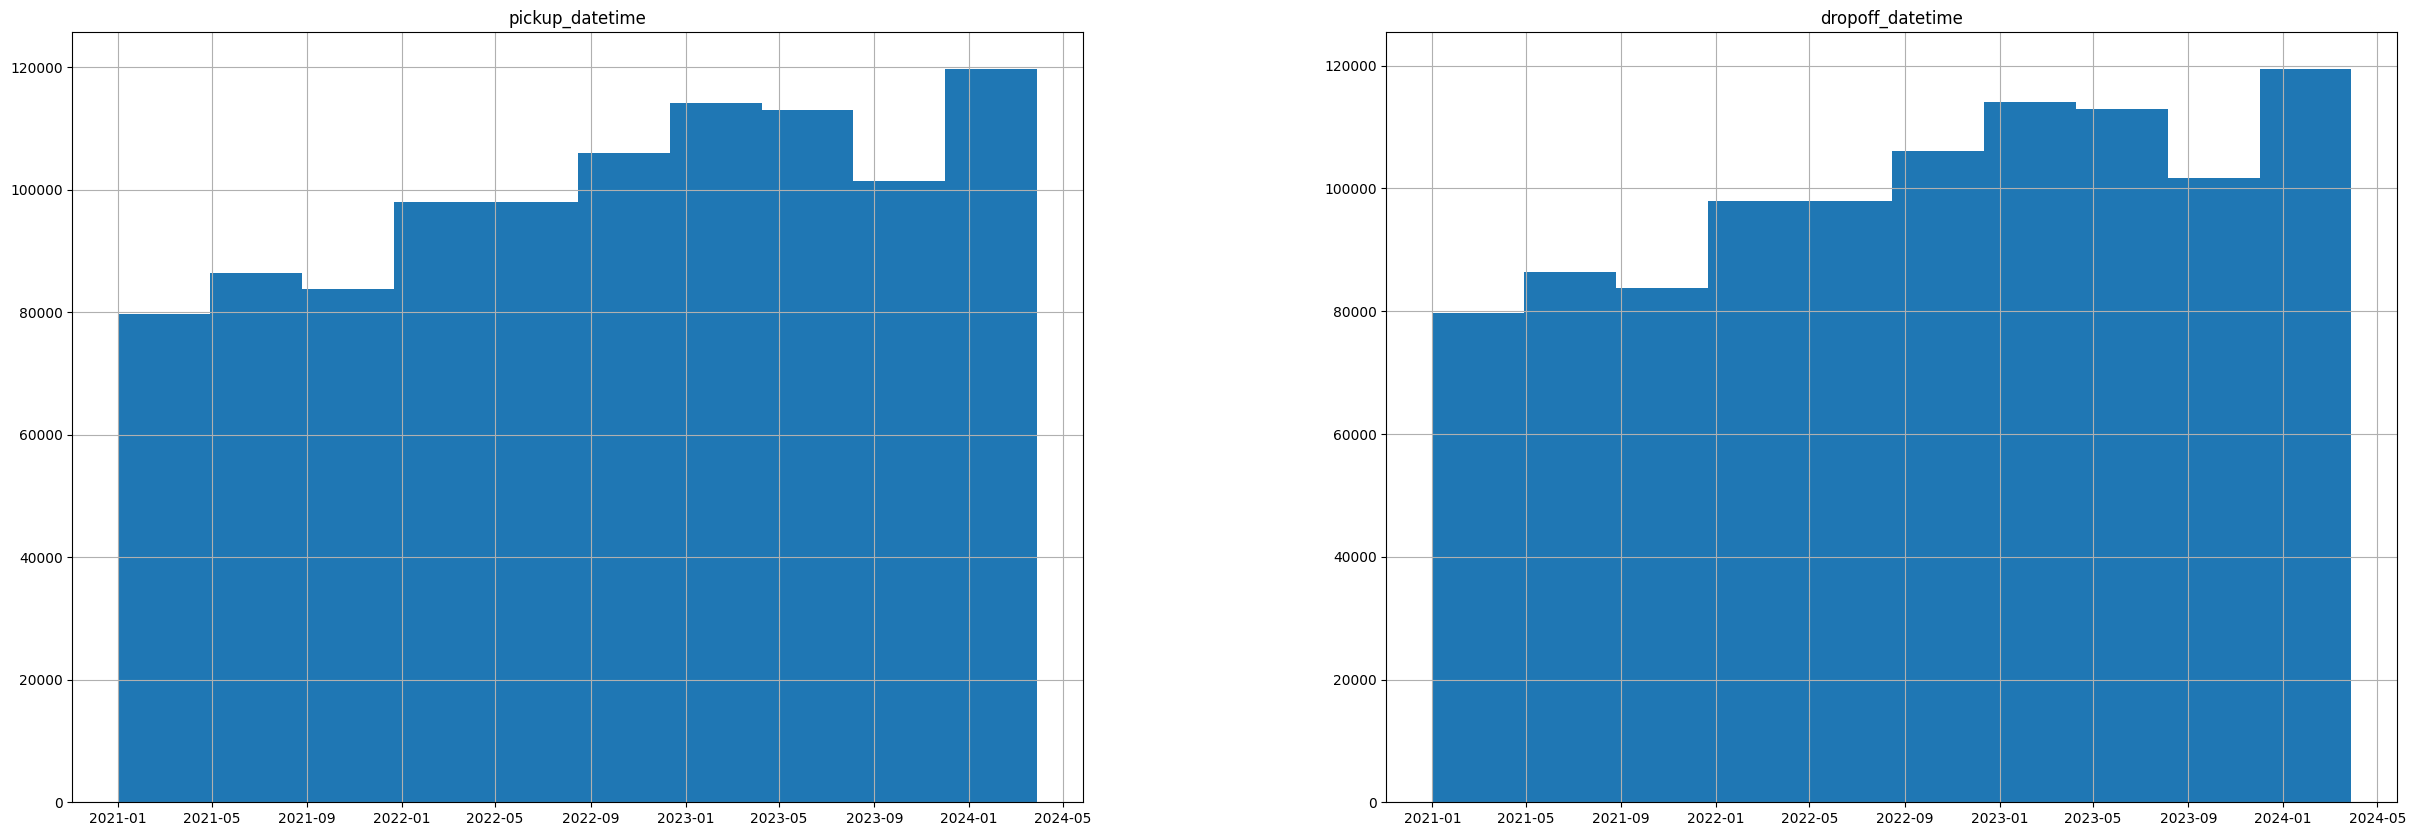

In [26]:
df_sample.hist(figsize=(30, 10))

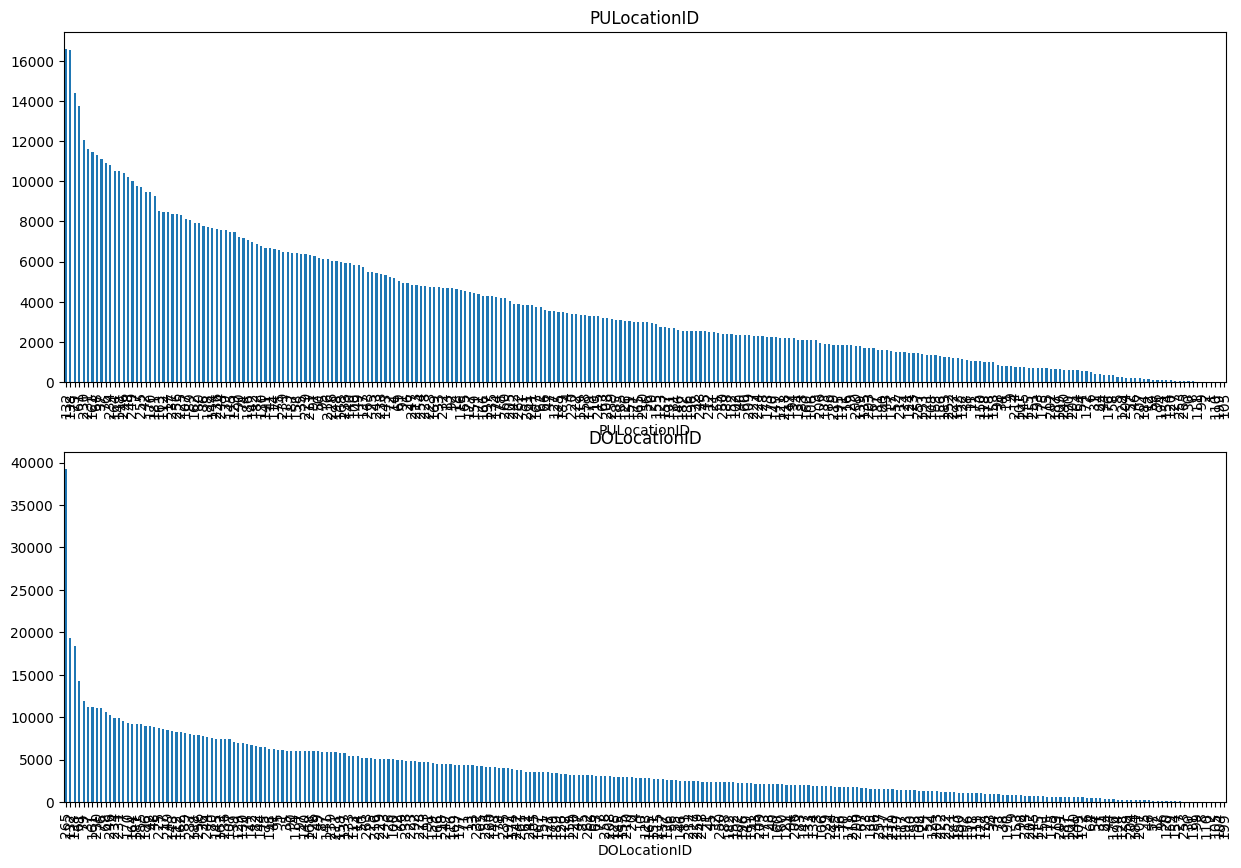

In [27]:
# Plot categoric columns
num_rows = 2

# Create a single figure with subplots arranged in a 2-column grid
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(15, 5*num_rows))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over each column
for i, column in enumerate(category_columns):
    # Plot each bar plot on its corresponding subplot
    df_sample[column].value_counts(dropna=False).plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)

for j in range(len(category_columns), 2):
    fig.delaxes(axes[j])

plt.show()

In [28]:
# Look once again at the summary stats table for categorical features
df_table_categoric = df[category_columns].describe().T
category_columns_perc_missing  = 100 * (df[category_columns].isnull().sum()/df.shape[0])
df_category_perc_missing = pd.DataFrame(category_columns_perc_missing, columns=['%missing'])
# cardinality
category_columns_card = df[category_columns].nunique()
df_category_card = pd.DataFrame(category_columns_card, columns=['card'])

In [43]:
print("Missing values")
df.isnull().sum()

Missing values


pickup_datetime     0
dropoff_datetime    0
PULocationID        0
DOLocationID        0
dtype: int64

In [44]:
print("Nan values")
df.isna().sum()

Nan values


pickup_datetime     0
dropoff_datetime    0
PULocationID        0
DOLocationID        0
dtype: int64

In [29]:
second_val = []
second_freq = []
for category in category_columns:
    # print(df[category].value_counts().index.tolist())
    second_val.append(df[category].value_counts().index.tolist()[1])
    second_freq.append(df[category].value_counts().iloc[1])

In [45]:
# Concatenate numeric, missing and cardinality cols
df_categoric_columns_data_quality_report_table = pd.concat([df_table_categoric, df_category_perc_missing, df_category_card], axis=1)

df_categoric_columns_data_quality_report_table['second'] = second_val
df_categoric_columns_data_quality_report_table['second_freq'] = second_freq

df_categoric_columns_data_quality_report_table = df_categoric_columns_data_quality_report_table[['count', 'unique', 'top', 'freq', 'second', 'second_freq', '%missing', 'card']]
# Print data quality report table for numeric features to a file.
df_categoric_columns_data_quality_report_table.to_csv("FHVHV-Taxi-DataQualityReport-CategoricFeatures-Table.csv", 
                                         index_label='Feature')
df_categoric_columns_data_quality_report_table

,count,unique,top,freq,second,second_freq,%missing,card
PULocationID,138521711,262,138,2292361,132,2291029,0.0,262
DOLocationID,138521711,263,265,5471778,132,2693935,0.0,263


In [46]:
# Concatenate numeric, missing and cardinality cols
df_numeric_columns_data_quality_report_table = pd.concat([df_table_numeric, df_numeric_missing, df_numeric_card], axis=1)

# Print data quality report table for numeric features to a file.
df_numeric_columns_data_quality_report_table.to_csv("FHVHV-Taxi-DataQualityReport-NumericFeatures-Table.csv", 
                                         index_label='Feature')
df_numeric_columns_data_quality_report_table

,count,mean,min,25%,50%,75%,max,%missing,card
pickup_datetime,138521711,2022-09-23 20:05:12.121333,2021-01-01 00:00:00,2021-12-23 16:05:56,2022-10-16 10:56:10,2023-07-10 09:16:35,2024-03-28 16:59:59,0.0,20622121
dropoff_datetime,138521711,2022-09-23 20:24:20.928783,2021-01-01 00:02:42,2021-12-23 16:22:25.500000,2022-10-16 11:13:14,2023-07-10 09:36:21,2024-03-28 21:08:24,0.0,20797430


### Logical integrity tests
1. dropoff not before pickup
2. Pickup date before 2021
3. Dropoff date > 31st Mar 2024
4. Duration of taxi ride > 5hrs
5. PU location ID not an allowed value
6. DO location ID not an allowed value



In [32]:
# Test 1: 
df[df['dropoff_datetime']<df['pickup_datetime']]

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
29449058,2021-11-07 01:40:31,2021-11-07 01:07:44,258,209
29449063,2021-11-07 01:58:09,2021-11-07 01:46:35,223,265
29449065,2021-11-07 01:47:47,2021-11-07 01:17:00,148,68
29449072,2021-11-07 01:40:55,2021-11-07 01:10:12,158,146
29449084,2021-11-07 01:52:38,2021-11-07 01:02:13,100,158
...,...,...,...,...
29504060,2021-11-07 01:56:34,2021-11-07 01:05:09,211,33
29504068,2021-11-07 01:53:12,2021-11-07 01:03:40,79,249
29504072,2021-11-07 01:48:47,2021-11-07 01:05:16,87,255
29504074,2021-11-07 01:48:46,2021-11-07 01:20:35,61,75


In [33]:
# Test 2: 
df[df['pickup_datetime']<pd.to_datetime('2021-01-01')]

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID


In [34]:
df[df['pickup_datetime']<pd.to_datetime('2021-01-01')].count()

pickup_datetime     0
dropoff_datetime    0
PULocationID        0
DOLocationID        0
dtype: int64

In [35]:
# Test 3: 
df[df['dropoff_datetime']>pd.to_datetime('2024-04-01')]

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID


In [36]:
late_dropoff = df[df['dropoff_datetime']>pd.to_datetime('2024-04-01')]
late_dropoff.describe().T

,count,mean,min,25%,50%,75%,max
pickup_datetime,0,NaT,NaT,NaT,NaT,NaT,NaT
dropoff_datetime,0,NaT,NaT,NaT,NaT,NaT,NaT


In [37]:
# Test 5:
time_diff = pd.Timedelta(hours=5)
df[df['dropoff_datetime']-df['pickup_datetime'] > time_diff]

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
222737,2021-01-01 13:56:33,2021-01-01 19:42:10,213,18
299230,2021-01-01 17:00:39,2021-01-01 22:22:44,92,265
512478,2021-01-02 12:26:35,2021-01-02 17:30:12,132,265
576758,2021-01-02 15:30:35,2021-01-02 21:50:02,241,265
654809,2021-01-02 19:06:59,2021-01-03 00:44:06,220,259
...,...,...,...,...
137122394,2024-03-20 12:53:03,2024-03-20 17:58:44,42,146
137212560,2024-03-20 15:19:02,2024-03-20 21:22:12,220,220
137591817,2024-03-27 08:54:23,2024-03-27 14:48:02,89,95
138133014,2024-03-28 03:19:47,2024-03-28 09:04:21,186,91


In [38]:
long_rides = df[df['dropoff_datetime']-df['pickup_datetime'] > time_diff]
long_rides['time_diff'] = long_rides['dropoff_datetime']-long_rides['pickup_datetime']
long_rides.describe().T

C:\Users\Daniel\AppData\Local\Temp\ipykernel_21568\3331555134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_rides['time_diff'] = long_rides['dropoff_datetime']-long_rides['pickup_datetime']


,count,mean,min,25%,50%,75%,max,std
pickup_datetime,1606,2022-08-27 00:20:29.123910,2021-01-01 13:56:33,2022-04-04 12:38:55.250000,2022-07-21 14:10:27,2023-04-13 17:44:52.500000,2024-03-28 11:52:02,NaN
dropoff_datetime,1606,2022-08-27 07:22:11.336239,2021-01-01 19:42:10,2022-04-04 20:48:31.250000,2022-07-21 21:19:10.500000,2023-04-14 00:32:36.750000,2024-03-28 17:26:55,NaN
time_diff,1606,0 days 07:01:42.212328,0 days 05:00:08,0 days 05:38:05.750000,0 days 06:41:25,0 days 08:04:24.750000,1 days 17:05:18,0 days 02:00:03.536886


In [39]:
# Test 6:
taxi_lookup = pd.read_csv('taxi_zone_lookup.csv')
taxi_zones = set(taxi_lookup['LocationID'])
df[~(df['PULocationID'].isin(taxi_zones) | df['PULocationID'].isna())]

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID


In [40]:
# Test 7:
df[~(df['DOLocationID'].isin(taxi_zones) | df['DOLocationID'].isna()) ]

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
